In [1]:
#pip install openpyxl

In [9]:
# Import 3rd party libraries
import os
import json
import pandas as pd
import xml.etree.ElementTree as ET
import datetime as dt



Task Status:
TTC Subway-
TTC Bus- Done but graph looks weird
Ottawa Bus- Have a dataframe with arrival/ departure times (still need to calculate delay)
Go Train- Need to reformat file?

TORONTO SUBWAY DATA (TTC)

In [3]:
#Pulling ttc subway files from 2018 onward TODO: Should we include back to 2014?
ttc_subway_files = [file for file in os.listdir() if 'ttc-subway-delay-data-20' in file]

dfs=[]

# Loop through the selected subway files, create individual dataframes for each sheet, and add dfs to a list 
for file in ttc_subway_files:
    sheet_names = pd.ExcelFile(file).sheet_names
    for sheet in sheet_names:
        temp_df = pd.read_excel(file, sheet_name= sheet)
        dfs.append(temp_df)
    
# Concatenate all individual DataFrames from the list into a single DataFrame
ttc_subway_df = pd.concat(dfs, ignore_index=True)

In [4]:
#ttc_subway_df.plot(x= "Date", y='Min Delay')
print(ttc_subway_df.info())
ttc_subway_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108004 entries, 0 to 108003
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       108004 non-null  datetime64[ns]
 1   Time       108004 non-null  object        
 2   Day        108004 non-null  object        
 3   Station    108004 non-null  object        
 4   Code       108004 non-null  object        
 5   Min Delay  108004 non-null  int64         
 6   Min Gap    108004 non-null  int64         
 7   Bound      79240 non-null   object        
 8   Line       107675 non-null  object        
 9   Vehicle    108004 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 8.2+ MB
None


,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2018-01-01,00:29,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986
1,2018-01-01,01:07,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0
2,2018-01-01,01:22,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751
3,2018-01-01,01:28,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222
4,2018-01-01,01:39,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781


<Axes: xlabel='Date'>

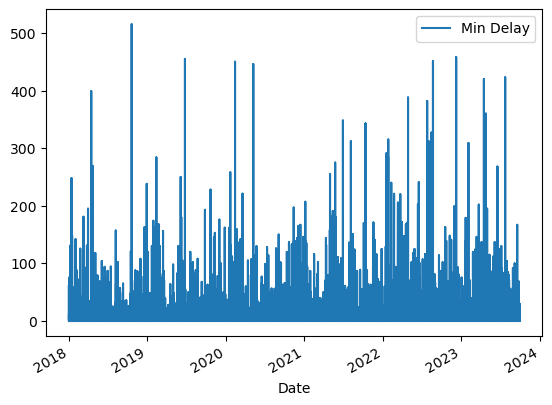

In [5]:
ttc_subway_df.plot(x= "Date", y='Min Delay')

In [6]:
#Exporting dataframe to CSV
ttc_subway_df.to_csv('ttc_subway_df.csv', index='False')

TORONTO BUS DATA (TTC)

In [7]:
#TORONTO BUS
ttc_bus_files= ['ttc-bus-delay-data-2018.xlsx','ttc-bus-delay-data-2019.xlsx', 
                 'ttc-bus-delay-data-2020.xlsx','ttc-bus-delay-data-2021.xlsx',
                 'ttc-bus-delay-data-2022.xlsx','ttc-bus-delay-data-2023.xlsx']

dfs=[]
# Loop through the selected subway files, create individual dataframes, and add dfs to a list 
for file in ttc_bus_files:
    sheet_names = pd.ExcelFile(file).sheet_names
    for sheet in sheet_names:
        temp_df = pd.read_excel(file, sheet_name= sheet, engine='openpyxl')
        dfs.append(temp_df)
    
# Concatenate all individual DataFrames from the list into a single DataFrame
ttc_bus_df = pd.concat(dfs, ignore_index=True)

KeyboardInterrupt: 

In [ ]:
#Cleaning DataFrame
ttc_bus_df['Report Date'].fillna(ttc_bus_df['Date'], inplace=True)
ttc_bus_df['Min Gap'].fillna(ttc_bus_df['Gap'], inplace=True)
ttc_bus_df['Min Delay'].fillna(ttc_bus_df['Delay'], inplace=True)
ttc_bus_df[' Min Delay'].fillna(ttc_bus_df['Delay'], inplace=True)
ttc_bus_df['Route'].fillna(ttc_bus_df['Line'], inplace=True)

In [ ]:
ttc_bus_df.drop(columns=['Date', 'Incident ID', ' Min Delay', 'Delay', 'Gap', 'Line', 'Bound', 'Unnamed: 10'], inplace = True)

In [ ]:
# ttc_bus_df[ttc_bus_df['Unnamed: 10'].notnull() == True]
print(ttc_bus_df.info())
ttc_bus_df.head()

In [ ]:
ttc_bus_df.plot(x= "Report Date", y='Min Delay')
#This graph looks suspicious

In [ ]:
#Exporting dataframe to CSV
ttc_bus_df.to_csv('ttc_bus_df.csv', index='False')

OTTAWA BUS DATA (OC TRANSPORT)

In [10]:
#OTTAWA BUS??
#Import OCTransport data- Ottawa
oct_file = json.load(open('octranspo_output.json', encoding='utf8'))

In [11]:
#Get values from JSON file to Dataframe
#Data pulled on Nov 7, 2023 at 17:06:00 <--ending time 
#Scale time 1 sec  per call
rows=[]
for bus_stop in oct_file:
    stop_no = oct_file[bus_stop]['GetRouteSummaryForStopResult']["StopNo"]
    #Format changes after this point and breaks code
    if bus_stop == '7523':
        break
    stop_description = oct_file[bus_stop]['GetRouteSummaryForStopResult']["StopDescription"]
    #print(bus_stop)
    
    #Added to fix issue with for loop when only one route number in "Routes"
    if isinstance(oct_file[bus_stop]['GetRouteSummaryForStopResult']['Routes']['Route'], dict):
        routes = [oct_file[bus_stop]['GetRouteSummaryForStopResult']['Routes']['Route']]
    else:
        routes = oct_file[bus_stop]['GetRouteSummaryForStopResult']['Routes']['Route']
        
    for route_no in routes:
        #print(route_no)
        #print(' ')
        route_number = route_no['RouteNo']
        for trip in route_no['Trips']['Trip']: 
            #print(trip)
            longitude = trip['Longitude']
            latitude = trip['Latitude']
            gps_speed = trip['GPSSpeed']
            trip_start_time = trip['TripStartTime']
            adj_sched_time = trip['AdjustedScheduleTime']
            adj_age = trip['AdjustmentAge']
        
            rows.append({
                'bus_stop': bus_stop,
                'stop_code': stop_no,
                'stop_description': stop_description,
                'route_number': route_number,
                'longitude': longitude,
                'latitude': latitude,
                'gps_speed': gps_speed,
                'trip_start_time': trip_start_time,
                'adj_sched_time': adj_sched_time,
                'adj_age': adj_age
            })

bus_info = pd.DataFrame(rows)

bus_info['stop_code'] = bus_info['stop_code'].astype('int')
bus_info['trip_start_time'] = pd.to_datetime(bus_info['trip_start_time'], format='%H:%M').dt.time

bus_info.head()

,bus_stop,stop_code,stop_description,route_number,longitude,latitude,gps_speed,trip_start_time,adj_sched_time,adj_age
0,6941,4055,CHESTERTON / ASSINIBOINE,111,-75.72068887007863,45.35138501619038,18,14:43:00,1,0.93
1,6941,4055,CHESTERTON / ASSINIBOINE,111,-75.7063585478684,45.375254269303944,12,14:58:00,14,0.65
2,6941,4055,CHESTERTON / ASSINIBOINE,111,,,,15:12:00,28,-1
3,572,4055,CHESTERTON / ASSINIBOINE,111,-75.72068887007863,45.35138501619038,18,14:43:00,1,0.93
4,572,4055,CHESTERTON / ASSINIBOINE,111,-75.7063585478684,45.375254269303944,12,14:58:00,14,0.65


In [12]:
bus_info.shape

(4201, 10)

In [13]:
#Creating a loop to account for delay in call time
index= len(bus_info)-1
temp_stop = bus_info.iloc[index]['bus_stop']
temp_time = pd.to_datetime('17:06:00')

while index >= 0:
    if temp_stop == bus_info.iloc[index]['bus_stop']:
        bus_info.loc[index, 'call_time'] = temp_time
    else:
        temp_stop = bus_info.iloc[index]['bus_stop']
        temp_time = temp_time - pd.Timedelta(seconds=1)
        bus_info.loc[index, 'call_time'] = temp_time
    
    index= index-1  

#Create a column 'est_arrival_time' which is equal to the call time 
bus_info

,bus_stop,stop_code,stop_description,route_number,longitude,latitude,gps_speed,trip_start_time,adj_sched_time,adj_age,call_time
0,6941,4055,CHESTERTON / ASSINIBOINE,111,-75.72068887007863,45.35138501619038,18,14:43:00,1,0.93,2023-11-29 16:42:39
1,6941,4055,CHESTERTON / ASSINIBOINE,111,-75.7063585478684,45.375254269303944,12,14:58:00,14,0.65,2023-11-29 16:42:39
2,6941,4055,CHESTERTON / ASSINIBOINE,111,,,,15:12:00,28,-1,2023-11-29 16:42:39
3,572,4055,CHESTERTON / ASSINIBOINE,111,-75.72068887007863,45.35138501619038,18,14:43:00,1,0.93,2023-11-29 16:42:40
4,572,4055,CHESTERTON / ASSINIBOINE,111,-75.7063585478684,45.375254269303944,12,14:58:00,14,0.65,2023-11-29 16:42:40
...,...,...,...,...,...,...,...,...,...,...,...
4196,4912,4149,FIELDING / RANKIN,290,,,,16:06:00,41,-1,2023-11-29 17:05:59
4197,4912,4149,FIELDING / RANKIN,290,,,,16:35:00,70,-1,2023-11-29 17:05:59
4198,4921,4149,FIELDING / RANKIN,290,-75.68109829325071,45.37823298279668,20,15:41:00,15,0.30,2023-11-29 17:06:00
4199,4921,4149,FIELDING / RANKIN,290,,,,16:06:00,41,-1,2023-11-29 17:06:00


In [14]:
bus_info.shape

(4201, 11)

In [15]:
#Create stops dataframe
stops = pd.read_csv('google_transit/stops.txt', delimiter=',')
#Only want last three number in stop_id
# stops['stop_id'] = stops['stop_id'].apply(lambda x: x[-3:])
stops_reduced= stops[['stop_id', 'stop_code']]
stops_reduced.head()

,stop_id,stop_code
0,AA010,8767.0
1,AA020,6859.0
2,AA030,7001.0
3,AA035,8762.0
4,AA040,7000.0


In [16]:
stops_reduced.shape

(5816, 2)

In [17]:
#Create stop times dataframe
stop_times = pd.read_csv('google_transit\stop_times.txt', delimiter=',')
#Only want last three number in stop_id
#stop_times['stop_id'] = stop_times['stop_id'].apply(lambda x: x[-3:])

#Trying to convert to datetimes
arrival_time = stop_times['arrival_time'].to_list()
print(arrival_time[0:5])

arrival_time_collected = []
for index in arrival_time:
    time = index.split(':')
    hour = int(time[0])
    if hour > 23:
        hour = hour - 24
    minutes= int(time[1])
    seconds= int(time[2])
    arrival_time_collected.append(pd.to_datetime(f"{hour:02d}:{minutes:02d}:{seconds:02d}"))

stop_times["arrival_datetime"] = arrival_time_collected

stop_times["start_time"] = stop_times["arrival_time"]

stop_times.shape

# split_times = [x.strip() for x in arrival_time.split(':')] #Split by space
# print(split_times)
# 
# hours=str(split_times[0::2])
# minutes= split_times[1::2]
# seconds= split_times[2::2]
# print(hours)
# 
# hours_final = [(hours[x].split(' ')[-1:]) for x in hours]
# print(hours_final)
# # print(split_times[0].split(' ')[-1:])
# 
# if int(arrival_time.split(':')[0]) > 23:
#     stop_times['arrival_time'] = arrival_time_str.replace(arrival_time_str.split(':')[0], '00', 1)
# 
# stop_times['arrival_time'] = pd.to_datetime(stop_times['arrival_time'], format='%H:%M:%S').dt.time
# 
# #NOTE: Departure time and arrival time are the same
stop_times_reduced= stop_times[['stop_id', "start_time", 'stop_sequence', "arrival_datetime"]]
# 
# stop_times_reduced.head()

['08:56:00', '08:57:00', '08:57:00', '08:57:00', '08:58:00']


In [18]:

stop_times_reduced.shape


(1099287, 4)

In [19]:
#Merge stop times and stops on stop id
stop_times_merged = pd.merge(left= stop_times_reduced, right= stops_reduced, on='stop_id')
stop_times_merged.head(20)

,stop_id,start_time,stop_sequence,arrival_datetime,stop_code
0,WR161,08:56:00,1,2023-11-29 08:56:00,5900.0
1,WR161,07:12:00,1,2023-11-29 07:12:00,5900.0
2,WR161,05:39:00,16,2023-11-29 05:39:00,5900.0
3,WR161,06:36:00,16,2023-11-29 06:36:00,5900.0
4,WR235,08:57:00,2,2023-11-29 08:57:00,6278.0
5,WR235,15:29:00,76,2023-11-29 15:29:00,6278.0
6,WR235,07:13:00,2,2023-11-29 07:13:00,6278.0
7,WR235,05:40:00,17,2023-11-29 05:40:00,6278.0
8,WR235,06:37:00,17,2023-11-29 06:37:00,6278.0
9,WR235,16:36:00,25,2023-11-29 16:36:00,6278.0


In [20]:
stop_times_merged.shape

(1099287, 5)

In [21]:
bus_info_with_times= pd.merge(left=bus_info, right=stop_times_merged, left_on=['stop_code', "trip_start_time"], right_on=['stop_code', "start_time"], how='left')
bus_info_with_times.head(100)

,bus_stop,stop_code,stop_description,route_number,longitude,latitude,gps_speed,trip_start_time,adj_sched_time,adj_age,call_time,stop_id,start_time,stop_sequence,arrival_datetime
0,6941,4055,CHESTERTON / ASSINIBOINE,111,-75.72068887007863,45.35138501619038,18,14:43:00,1,0.93,2023-11-29 16:42:39,NaN,NaN,NaN,NaT
1,6941,4055,CHESTERTON / ASSINIBOINE,111,-75.7063585478684,45.375254269303944,12,14:58:00,14,0.65,2023-11-29 16:42:39,NaN,NaN,NaN,NaT
2,6941,4055,CHESTERTON / ASSINIBOINE,111,,,,15:12:00,28,-1,2023-11-29 16:42:39,NaN,NaN,NaN,NaT
3,572,4055,CHESTERTON / ASSINIBOINE,111,-75.72068887007863,45.35138501619038,18,14:43:00,1,0.93,2023-11-29 16:42:40,NaN,NaN,NaN,NaT
4,572,4055,CHESTERTON / ASSINIBOINE,111,-75.7063585478684,45.375254269303944,12,14:58:00,14,0.65,2023-11-29 16:42:40,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3636,4055,CHESTERTON / ASSINIBOINE,111,,,,15:12:00,28,-1,2023-11-29 16:43:10,NaN,NaN,NaN,NaT
96,4338,4055,CHESTERTON / ASSINIBOINE,111,-75.72068887007863,45.35138501619038,18,14:43:00,1,1.42,2023-11-29 16:43:11,NaN,NaN,NaN,NaT
97,4338,4055,CHESTERTON / ASSINIBOINE,111,-75.7063585478684,45.375254269303944,12,14:58:00,14,1.13,2023-11-29 16:43:11,NaN,NaN,NaN,NaT
98,4338,4055,CHESTERTON / ASSINIBOINE,111,,,,15:12:00,28,-1,2023-11-29 16:43:11,NaN,NaN,NaN,NaT


In [22]:
bus_info_with_times.shape

(4201, 15)

In [23]:
#TODO: Calculate Delay
# bus_info_with_times['difference'] = bus_info_with_times['arrival_datetime']-bus_info_with_times['trip_start_time']
# bus_info_with_times

bus_times_delta = []
temp = 0

for x in bus_info_with_times["adj_sched_time"]:
    x = int(x)
    temp = bus_info_with_times["call_time"] + dt.timedelta(minutes=x)
    bus_times_delta.append(temp)
    
bus_info_with_times["call_time_plus_adj"] = bus_times_delta

bus_info_with_times.head()

# bus_info_with_times['call_time_plus_adj'] = dt.datetime.combine(dt.datetime(2023, 11, 28), dt.time(seconds = bus_info_with_times['adj_sched_time'])) + bus_info_with_times['call_time']

,bus_stop,stop_code,stop_description,route_number,longitude,latitude,gps_speed,trip_start_time,adj_sched_time,adj_age,call_time,stop_id,start_time,stop_sequence,arrival_datetime,call_time_plus_adj
0,6941,4055,CHESTERTON / ASSINIBOINE,111,-75.72068887007863,45.35138501619038,18,14:43:00,1,0.93,2023-11-29 16:42:39,NaN,NaN,NaN,NaT,0 2023-11-29 16:43:39 1 2023-11-29 1...
1,6941,4055,CHESTERTON / ASSINIBOINE,111,-75.7063585478684,45.375254269303944,12,14:58:00,14,0.65,2023-11-29 16:42:39,NaN,NaN,NaN,NaT,0 2023-11-29 16:56:39 1 2023-11-29 1...
2,6941,4055,CHESTERTON / ASSINIBOINE,111,,,,15:12:00,28,-1,2023-11-29 16:42:39,NaN,NaN,NaN,NaT,0 2023-11-29 17:10:39 1 2023-11-29 1...
3,572,4055,CHESTERTON / ASSINIBOINE,111,-75.72068887007863,45.35138501619038,18,14:43:00,1,0.93,2023-11-29 16:42:40,NaN,NaN,NaN,NaT,0 2023-11-29 16:43:39 1 2023-11-29 1...
4,572,4055,CHESTERTON / ASSINIBOINE,111,-75.7063585478684,45.375254269303944,12,14:58:00,14,0.65,2023-11-29 16:42:40,NaN,NaN,NaN,NaT,0 2023-11-29 16:56:39 1 2023-11-29 1...


In [24]:
bus_info_with_times.shape

(4201, 16)

In [25]:
bus_info_with_times.to_csv("OC_Transpo_Bus_Info_With_Times.csv")

GO TRAIN DATA

In [32]:
go_file = json.load(open('gotrain_output.json', encoding='utf8'))
print(go_file)
##TODO: Stuck because I can't reference any strings, only integers
go_file_new= go_file["entity"]
go_file_new

{
  "header": {
    "gtfs_realtime_version": "1.0",
    "incrementality": "FULL_DATASET",
    "timestamp": 1699298448
  },
  "entity": [
    {
      "id": "20231106-LW-1019",
      "is_deleted": false,
      "trip_update": {
        "trip": {
          "trip_id": "20231106-LW-1019",
          "route_id": "09231223-LW",
          "direction_id": 1,
          "start_time": "13:17:00",
          "start_date": "20231106",
          "schedule_relationship": "SCHEDULED"
        },
        "vehicle": {
          "id": "667",
          "label": "LW - Aldershot GO",
          "license_plate": ""
        },
        "stop_time_update": [
          {
            "stop_id": "AL",
            "arrival": null,
            "departure": {
              "delay": 18,
              "time": 1699298778,
              "uncertainty": 0
            },
            "schedule_relationship": "SCHEDULED"
          }
        ],
        "timestamp": 1699298430,
        "delay": 18
      },
      "vehicle": null,
    

TypeError: string indices must be integers

VANCOUVER BUS DATA (TRANSLINK)

In [15]:
#VANCOUVER
tl_file= 'translink_data.xml'

# Parse the XML file
tree = ET.parse(tl_file)
root = tree.getroot()

# Extract data from XML and create a list of dictionaries
tl_bus_data_list = []
for item in root.findall('Bus'):
    data = {}
    data['VehicleNo'] = item.find('VehicleNo').text
    data['TripId'] = item.find('TripId').text
    data['RouteNo'] = item.find('RouteNo').text
    data['Direction'] = item.find('Direction').text
    data['Destination'] = item.find('Destination').text
    data['Pattern'] = item.find('Pattern').text
    data['Latitude'] = item.find('Latitude').text
    data['Longitude'] = item.find('Longitude').text
    data['RecordedTime'] = item.find('RecordedTime').text
    
    tl_bus_data_list.append(data)

# Create a DataFrame from the list of dictionaries
tl_bus_df = pd.DataFrame(tl_bus_data_list)
tl_bus_df
#TODO: times but no dates...confused on how to get delay data from this

,VehicleNo,TripId,RouteNo,Direction,Destination,Pattern,Latitude,Longitude,RecordedTime
0,12001,13539101,049,WEST,UBC,WB1,49.222067,-123.024783,10:38:27 am
1,12003,13590009,049,EAST,METROTOWN STN,EB1,49.247100,-123.232083,10:38:48 am
2,12007,13590007,049,EAST,METROTOWN STN,EB1,49.226467,-123.005067,10:34:41 am
3,12008,13539007,049,EAST,METROTOWN STN,EB1,49.225950,-123.112367,10:38:45 am
4,12010,13590006,049,EAST,METROTOWN STN,EB1,49.226900,-123.006117,10:24:59 am
...,...,...,...,...,...,...,...,...,...
777,9784,13537178,028,NORTH,PHIBBS EXCH,N1,49.236233,-123.027667,10:38:22 am
778,9786,13556614,230,SOUTH,LONSDALE QUAY,S1,49.344833,-123.073733,10:38:14 am
779,9787,13556791,232,EAST,PHIBBS EXCH,E1,49.312200,-123.040417,10:38:56 am
780,9788,13556543,230,NORTH,UPPER LONSDALE,N1,49.320950,-123.072217,10:39:08 am
